# Chapter 4 - Classification

- [Load dataset](#Load-dataset)
- [The Default data set](#Figure-4.1---Default-data-set)
- [4.3 Logistic Regression](#4.3-Logistic-Regression)
- [4.4 Linear Discriminant Analysis](#4.4-Linear-Discriminant-Analysis)
- [Lab: 4.6.3 Linear Discriminant Analysis](#4.6.3-Linear-Discriminant-Analysis)
- [Lab: 4.6.4 Quadratic Discriminant Analysis](#4.6.4-Quadratic-Discriminant-Analysis)
- [Lab: 4.6.5 K-Nearest Neighbors](#4.6.5-K-Nearest-Neighbors)
- [Lab: 4.6.6 An Application to Caravan Insurance Data](#4.6.6-An-Application-to-Caravan-Insurance-Data)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

### Load dataset

In [2]:
# In R, I exported the dataset from package 'ISLR' to an Excel file
df = pd.read_excel('Data/Default.xlsx')

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

/home/lev/.local/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Unnamed: 0,default,student,balance,income,default2,student2
0,1,No,No,729.526495,44361.625074,0,0
1,2,No,Yes,817.180407,12106.134700,0,1
2,3,No,No,1073.549164,31767.138947,0,0


###  Figure 4.1 - Default data set

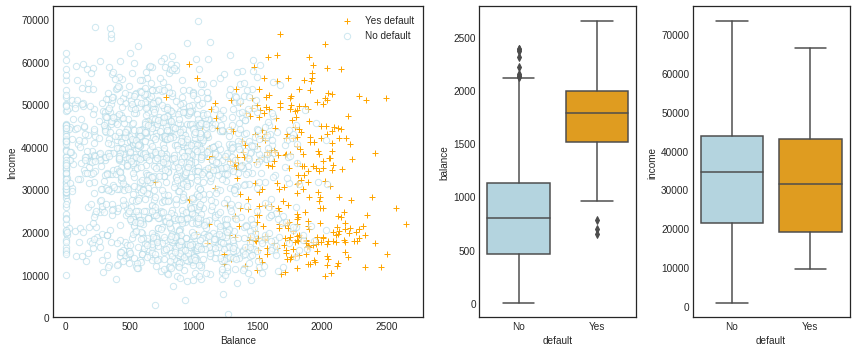

In [3]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = pd.concat([df_no, df_yes])

ax1.scatter(df_[df_.default == 'Yes'].balance, df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1, label="Yes default")
ax1.scatter(df_[df_.default == 'No'].balance, df_[df_.default == 'No'].income, s=40, marker='o', linewidths=1,
            edgecolors='lightblue', facecolors='white', alpha=.6, label="No default")

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')
ax1.legend()

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot(x='default', y='balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot(x='default', y='income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

## 4.3 Logistic Regression
### Figure 4.2

/home/lev/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


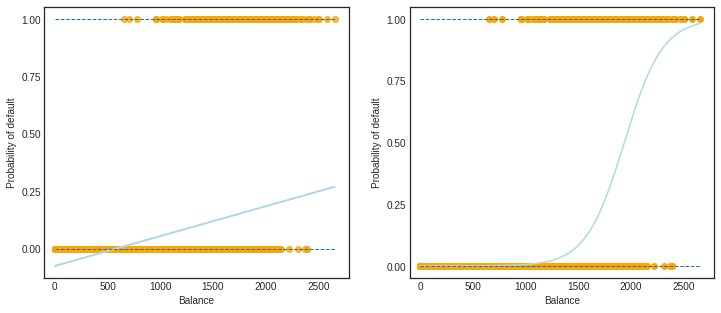

In [4]:
X_train = df.balance.values.reshape(-1,1) 
y = df.default2

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y)
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(df.balance, df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

### Table 4.1

In [5]:
y = df.default2

#####  scikit-learn

In [6]:
# Using newton-cg solver, the coefficients are equal/closest to the ones in the book. 
# I do not know the details on the differences between the solvers.
clf = skl_lm.LogisticRegression(solver='newton-cg')
X_train = df.balance.values.reshape(-1,1)
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(solver='newton-cg')
classes:  [0 1]
coefficients:  [[0.00549892]]
intercept : [-10.65132747]


##### statsmodels

In [7]:
X_train = sm.add_constant(df.balance)
est = sm.Logit(y.ravel(), X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


###  Table 4.2

In [8]:
X_train = sm.add_constant(df.student2)
y = df.default2

est = sm.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student2,0.404887,0.115019,3.520177,0.000431,0.179454,0.630320


In [9]:
# nonstudent
e1 = np.exp(est.params["const"])
# student
e2 = np.exp(est.params["const"] + est.params["student2"])
"{:.8f}".format(float(e1/(1+e1))), "{:.8f}".format(float(e2/(1+e2)))

('0.02919501', '0.04313859')

For non-students, the default rate is lower

###  Table 4.3 - Multiple Logistic Regression

In [10]:
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
est = sm.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.869045,0.492273,-22.079320,4.995499e-108,-11.833882,-9.904209
balance,0.005737,0.000232,24.736506,4.331521e-135,0.005282,0.006191
income,0.000003,0.000008,0.369808,7.115254e-01,-0.000013,0.000019
student2,-0.646776,0.236257,-2.737595,6.189022e-03,-1.109831,-0.183721


### Figure 4.3 - Confounding

In [11]:
# balance and default vectors for students
X_train = df[df.student == 'Yes'].balance.values.reshape(df[df.student == 'Yes'].balance.size,1) 
y = df[df.student == 'Yes'].default2

# balance and default vectors for non-students
X_train2 = df[df.student == 'No'].balance.values.reshape(df[df.student == 'No'].balance.size,1) 
y2 = df[df.student == 'No'].default2

# Vector with balance values for plotting
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf2 = skl_lm.LogisticRegression(solver='newton-cg')

clf.fit(X_train,y)
clf2.fit(X_train2,y2)

prob = clf.predict_proba(X_test)
prob2 = clf2.predict_proba(X_test)

In [13]:
df.groupby(['student','default']).size().unstack('default')

default,No,Yes
student,,
No,6850,206
Yes,2817,127


In [14]:
206/6850, 127/2817

(0.03007299270072993, 0.04508342208022719)

It is simillar to the probs we've obtain from simple logistic regression for student

In [19]:
# clf_t = skl_lm.LogisticRegression(solver='newton-cg')
# clf_t.fit(df["student2"], y)

/home/lev/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


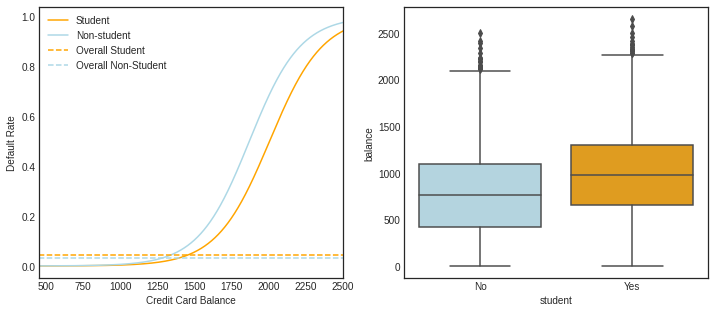

In [20]:
# creating plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.plot(X_test, pd.DataFrame(prob)[1], color='orange', label='Student')
ax1.plot(X_test, pd.DataFrame(prob2)[1], color='lightblue', label='Non-student')
ax1.hlines(127/2817, colors='orange', label='Overall Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(206/6850, colors='lightblue', label='Overall Non-Student',
           xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

# Right plot
sns.boxplot('student', 'balance', data=df, orient='v', ax=ax2,  palette=c_palette);

## 4.4 Linear Discriminant Analysis
### Table 4.4 


In [21]:
X = df[['balance', 'income', 'student2']].values
y = df.default2.values

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X, y).predict(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9645,254
Yes,22,79


In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, y_pred)

array([[9645,   22],
       [ 254,   79]])

In [23]:
print(classification_report(y, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.97      1.00      0.99      9667
         Yes       0.78      0.24      0.36       333

    accuracy                           0.97     10000
   macro avg       0.88      0.62      0.67     10000
weighted avg       0.97      0.97      0.97     10000



In [24]:
print("Accuracy:", (9645+79)/10000)
# among the ones that were classified as "x", how many where actually "x"?
print("Precision yes:", round(79/(79+22), 2))
print("Precision no:", round(9645/(9645+254), 2))
# among the "x"'s, how many where identified?
print("recall yes:", round(79/(79+254), 2))
print("recall no:", round(9645/(9645+22), 2))
# f1 -- harmonic mean of recall and precision
# reason for this: extra punish for low values

Accuracy: 0.9724
Precision yes: 0.78
Precision no: 0.97
recall yes: 0.24
recall no: 1.0


### Table 4.5
Instead of using the probability of 50% as decision boundary, we say that a probability of default of 20% is to be classified as 'Yes'.

In [55]:
decision_prob = 0.2
y_prob = lda.fit(X, y).predict_proba(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes', 'True':'Yes', 'False':'No'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
False,5282,260
True,192,88


#  Lab

### 4.6.3 Linear Discriminant Analysis

In [56]:
df = pd.read_csv('Data/Smarket.csv', usecols=range(1,10), index_col=0, parse_dates=True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1250 entries, 2001-01-01 to 2005-01-01
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Lag1       1250 non-null   float64
 1   Lag2       1250 non-null   float64
 2   Lag3       1250 non-null   float64
 3   Lag4       1250 non-null   float64
 4   Lag5       1250 non-null   float64
 5   Volume     1250 non-null   float64
 6   Today      1250 non-null   float64
 7   Direction  1250 non-null   object 
dtypes: float64(7), object(1)
memory usage: 87.9+ KB


In [58]:
df.describe()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


In [59]:
X = df.drop(columns=["Direction", "Today"])
y = df["Direction"]
y.replace({"Up": 1, "Down": 0}, inplace=True)

<AxesSubplot:ylabel='Volume'>

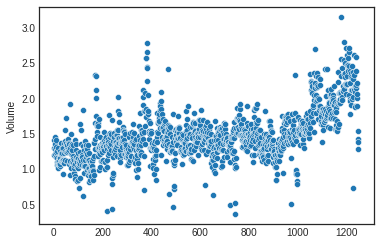

In [60]:
sns.scatterplot(x=np.arange(df.shape[0]), y=df["Volume"])

In [61]:
X_train = df[:'2004'][['Lag1','Lag2', "Lag3", "Lag4", "Lag5", "Volume"]]
y_train = df[:'2004']['Direction']
y_train.replace({"Up": 1, "Down": 0}, inplace=True)

X_test = df['2005':][['Lag1','Lag2', "Lag3", "Lag4", "Lag5", "Volume"]]
y_test = df['2005':]['Direction']
y_test.replace({"Up": 1, "Down": 0}, inplace=True)

lda = LinearDiscriminantAnalysis()
pred = lda.fit(X_train, y_train).predict(X_test)

/tmp/ipykernel_9020/1106103334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.replace({"Up": 1, "Down": 0}, inplace=True)
/tmp/ipykernel_9020/1106103334.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.replace({"Up": 1, "Down": 0}, inplace=True)


In [62]:
lda.predict_proba(X_test)

array([[0.47182571, 0.52817429],
       [0.48435194, 0.51564806],
       [0.477387  , 0.522613  ],
       [0.48615594, 0.51384406],
       [0.50162585, 0.49837415],
       [0.49887592, 0.50112408],
       [0.49720147, 0.50279853],
       [0.49042844, 0.50957156],
       [0.49597267, 0.50402733],
       [0.48935917, 0.51064083],
       [0.48988143, 0.51011857],
       [0.51874278, 0.48125722],
       [0.49469513, 0.50530487],
       [0.47640837, 0.52359163],
       [0.48318554, 0.51681446],
       [0.48747609, 0.51252391],
       [0.50173959, 0.49826041],
       [0.51165336, 0.48834664],
       [0.50394267, 0.49605733],
       [0.49479808, 0.50520192],
       [0.50887675, 0.49112325],
       [0.52093447, 0.47906553],
       [0.50868867, 0.49131133],
       [0.49436411, 0.50563589],
       [0.51103185, 0.48896815],
       [0.50319608, 0.49680392],
       [0.4915523 , 0.5084477 ],
       [0.48319404, 0.51680596],
       [0.49267934, 0.50732066],
       [0.51308768, 0.48691232],
       [0.

In [63]:
from statsmodels.tools.tools import add_constant

logit = sm.Logit(y, add_constant(X)).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Sat, 03 Sep 2022   Pseudo R-squ.:                0.002074
Time:                        13:31:38   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
Covariance Type:            nonrobust   LLR p-value:                    0.7319
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.050     -1.457      0.145      -0.171       0.025
Lag2          -0.0423      0.050     -0.845      0.398      -0.140       0.056
Lag3           0.0111      0.050      0.222      0.824      -0.087       0.109
Lag4           0.0094      0.050      0.187      0.851      -0.089       0.107
Lag5           0.0103      0.050      0.208      0.835      -0.087       0.107
Volume         0.1354      0.158      0.855      0.392      -0.175       0.446
==============================================================================
"""

In [64]:
from sklearn.linear_model import LogisticRegression

logit_sk = LogisticRegression().fit(X, y)

In [65]:
logit_sk.intercept_, logit_sk.coef_

(array([-0.12108463]),
 array([[-0.07284345, -0.04223481,  0.0110163 ,  0.00928427,  0.01026372,
          0.13211221]]))

In [66]:
confusion_matrix(y, logit_sk.predict(X)).T

array([[144, 141],
       [458, 507]])

In [67]:
print(classification_report(y, logit_sk.predict(X), digits=3))

              precision    recall  f1-score   support

           0      0.505     0.239     0.325       602
           1      0.525     0.782     0.629       648

    accuracy                          0.521      1250
   macro avg      0.515     0.511     0.477      1250
weighted avg      0.516     0.521     0.482      1250



In [68]:
logit_sk2 = LogisticRegression().fit(X_train, y_train)

In [69]:
confusion_matrix(y_test, logit_sk2.predict(X_test)).T

array([[74, 93],
       [37, 48]])

In [70]:
print(classification_report(y_test, logit_sk2.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.443     0.667     0.532       111
           1      0.565     0.340     0.425       141

    accuracy                          0.484       252
   macro avg      0.504     0.504     0.479       252
weighted avg      0.511     0.484     0.472       252



In [71]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.443     0.694     0.540       111
           1      0.564     0.312     0.402       141

    accuracy                          0.480       252
   macro avg      0.503     0.503     0.471       252
weighted avg      0.511     0.480     0.463       252



In [72]:
pred_p = lda.predict_proba(X_test)

In [73]:
np.unique(pred_p[:,1]>0.5, return_counts=True)

(array([False,  True]), array([174,  78]))

In [44]:
np.unique(pred_p[:,1]>0.9, return_counts=True)

(array([False]), array([252]))

### 4.6.4 Quadratic Discriminant Analysis

In [45]:
qda = QuadraticDiscriminantAnalysis()
pred = qda.fit(X_train, y_train).predict(X_test)

In [46]:
qda.priors_

array([0.49198397, 0.50801603])

In [47]:
qda.means_

array([[ 4.27902240e-02,  3.38940937e-02, -9.80651731e-03,
        -1.05987780e-02,  4.36659878e-03,  1.37184259e+00],
       [-3.95463511e-02, -3.13254438e-02,  5.83431953e-03,
         3.11045365e-03, -6.50887574e-04,  1.36320990e+00]])

In [48]:
confusion_matrix(y_test, pred).T

array([[ 82, 111],
       [ 29,  30]])

In [49]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.425     0.739     0.539       111
           1      0.508     0.213     0.300       141

    accuracy                          0.444       252
   macro avg      0.467     0.476     0.420       252
weighted avg      0.472     0.444     0.405       252



### 4.6.5 K-Nearest Neighbors

In [50]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred).T)
print(classification_report(y_test, pred, digits=3))

[[50 62]
 [61 79]]
              precision    recall  f1-score   support

           0      0.446     0.450     0.448       111
           1      0.564     0.560     0.562       141

    accuracy                          0.512       252
   macro avg      0.505     0.505     0.505       252
weighted avg      0.512     0.512     0.512       252



In [51]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
pred = knn.fit(X_train, y_train).predict(X_test)
print(confusion_matrix(y_test, pred).T)
print(classification_report(y_test, pred, digits=3))

[[48 62]
 [63 79]]
              precision    recall  f1-score   support

           0      0.436     0.432     0.434       111
           1      0.556     0.560     0.558       141

    accuracy                          0.504       252
   macro avg      0.496     0.496     0.496       252
weighted avg      0.503     0.504     0.504       252



### 4.6.6 An Application to Caravan Insurance Data

#### K-Nearest Neighbors

In [81]:
# In R, I exported the dataset from package 'ISLR' to a csv file
df = pd.read_csv('Data/Caravan.csv')
y = df.Purchase
X = df.drop('Purchase', axis=1).astype('float64')
X_scaled = preprocessing.scale(X)

X_train = X_scaled[1000:,:]
y_train = y[1000:]
X_test = X_scaled[:1000,:]
y_test = y[:1000]

def KNN(n_neighbors=1, weights='uniform'):
    clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    return(pred, score, clf.classes_)

def plot_confusion_matrix(cm, classes, n_neighbors, title='Confusion matrix (Normalized)',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized confusion matrix: KNN-{}'.format(n_neighbors))
    plt.colorbar()
    plt.xticks(np.arange(2), classes)
    plt.yticks(np.arange(2), classes)
    plt.tight_layout()
    plt.xlabel('True label',rotation='horizontal', ha='right')
    plt.ylabel('Predicted label')
    plt.show()

In [93]:
clf = neighbors.KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
score = clf.score(X_train, y_train)
score

1.0

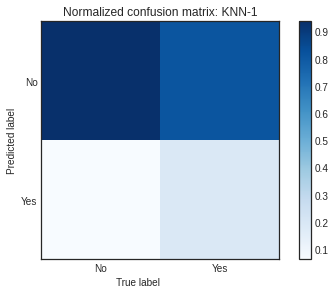

True        No  Yes
Predicted          
No         882   48
Yes         59   11
     Precision
No    0.948387
Yes   0.157143


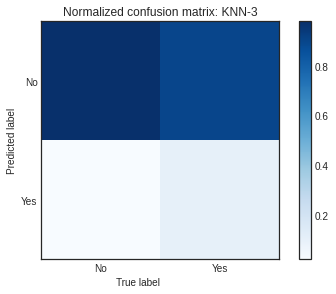

True        No  Yes
Predicted          
No         921   53
Yes         20    6
     Precision
No    0.945585
Yes   0.230769


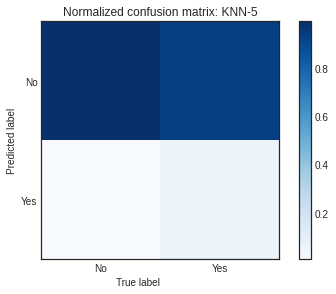

True        No  Yes
Predicted          
No         934   55
Yes          7    4
     Precision
No    0.944388
Yes   0.363636


In [83]:
for i in [1,3,5]:
    pred, score, classes = KNN(n_neighbors=i)
    cm = confusion_matrix(y_test, pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized.T, classes, n_neighbors=i)
    cm_df = pd.DataFrame(cm.T, index=classes, columns=classes)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print(cm_df)    
    print(pd.DataFrame(precision_score(y_test, pred, average=None),
                       index=classes, columns=['Precision']))        

####  Logistic Regression

In [ ]:
regr = skl_lm.LogisticRegression()
regr.fit(X_train, y_train)

In [ ]:
pred = regr.predict(X_test)
cm_df = pd.DataFrame(confusion_matrix(y_test, pred).T, index=regr.classes_,
                     columns=regr.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)
print(classification_report(y_test, pred))

In [ ]:
pred_p = regr.predict_proba(X_test)
cm_df = pd.DataFrame({'True': y_test, 'Pred': pred_p[:,1] > .25})
cm_df.Pred.replace(to_replace={True:'Yes', False:'No'}, inplace=True)
print(cm_df.groupby(['True', 'Pred']).size().unstack('True').T)
print(classification_report(y_test, cm_df.Pred))

In [84]:
def logit(b, x):
    return np.exp(x @ b)/(1 + np.exp(x @ b))

In [91]:
b=np.array([-6, 0.05, 1])
x1 = np.array([1, 40, 3.5])
x2 = np.array([1, 40, 5])
logit(b, x1) - logit(b, x2)

-0.35351790983185943